<a href="https://colab.research.google.com/github/ziatdinovmax/ActiveChannelLearning/blob/main/hmcDKL_channels_synthetic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we show how to learn the channel with best predictive capability in DKL-based active learning.

In [ ]:
!pip install -q git+https://github.com/ziatdinovmax/gpax@v0.0.3

In [ ]:
import warnings

import numpy as np
import matplotlib.pyplot as plt

import gpax

import numpyro
import jax
import jax.numpy as jnp

from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore", category=UserWarning)

gpax.utils.enable_x64()

/opt/homebrew/lib/python3.9/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


Let's create our synthetic dataset. Suppose $z$ are our structural parameters and $y$ is a scalar physical functionaity. We assume that $y = f(z)$ where $f$ is some non-linear function. We do not have direct access to $z$, but we do have access to high-dimensional noisy observations $X$ that measure the structure (and hence, contain information about parameters $z$).

Here, we experiment on simple synthetic data which we used previously to study VAEs. First, let's generate observations $X$:

In [ ]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

n_samples = 1000 # number of samples
l_signal = 50 # signal length

# Generate synthetic dataset with randomly shifted noisy 1D signal
np.random.seed(0)  # for reproducibility
x = np.linspace(-12, 12, l_signal)[None].repeat(n_samples, 0)
noise = np.random.randint(1, 40, (n_samples, 1)) / 1e3
amp = np.random.randint(100, 150, size=(n_samples, 1)) / 1e2
mu = np.random.randint(-30, 30, size=(n_samples, 1)) / 10
sig = np.random.randint(50, 500, size=(n_samples, 1)) / 1e2
X = amp * gaussian(x, mu, sig) + noise * np.random.randn(n_samples, l_signal)
# Normalize to (0, 1)
X = (X - X.min()) / (X.max() - X.min())

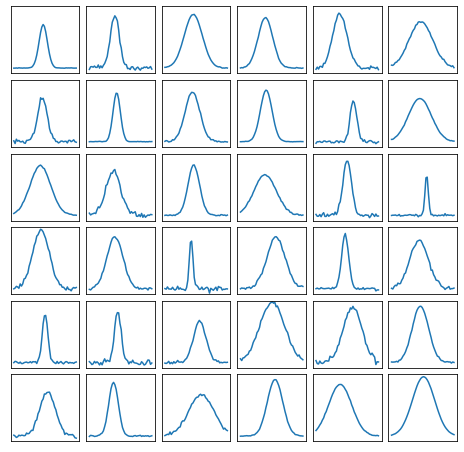

In [ ]:
fig, axes = plt.subplots(6, 6, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = np.random.randint(0, len(X))
    ax.plot(X[i])
    ax.set_ylim(0, 1)

Generate target $y$. Notice that not all structural information contained in $X$ is used to generate $y$ (no depenency on the amplitude)

In [ ]:
y = 0.5*mu**3 + 4*sig**2

# y -= y.min()
# y /= y.ptp()

y -= y.mean()
y /= y.std()

y = y.squeeze()

Not let's create the second channel. Recall that our goal is to distinguish between channels with different predictive capacity. For simplicity, we create the second channel by artificially reducing the predictive capacity of the initial channel. This is achieved by adding small random shifts to the peak position

In [ ]:
X1 = X
np.random.seed(0)
delta = np.random.randint(-100, 100, size=(n_samples, 1)) / 50
X2 = amp * gaussian(x, mu+delta, sig) + noise * np.random.randn(n_samples, l_signal)
X2 = (X2 - X2.min()) / (X2.max() - X2.min())

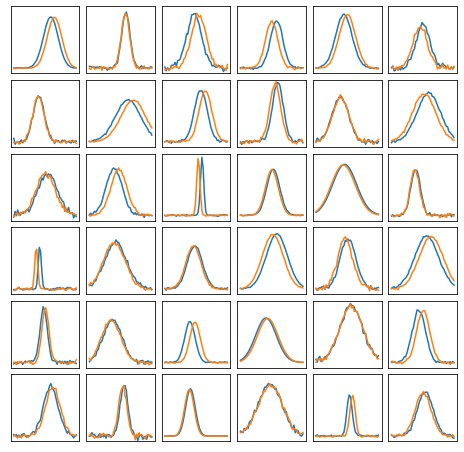

In [ ]:
fig, axes = plt.subplots(6, 6, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = np.random.randint(0, len(X))
    ax.plot(X1[i])
    ax.plot(X2[i])
    ax.set_ylim(0, 1)

Next, we define utility functions for inference, rewards, and data updates:

In [ ]:
def step_mcmc(X, y, X_new):
    key1, key2 = gpax.utils.get_keys()
    data_dim = X.shape[-1]
    dkl = gpax.DKL(data_dim, z_dim=2, kernel='RBF')
    dkl.fit(key1, X, y, num_warmup=2000, num_samples=2000)
    mean, samples = dkl.predict_in_batches(key2, X_new)
    var = samples.squeeze().var(0)
    return mean, var

def get_best_channel(record):
    return record[:,1].argmax()


def update_record(record, action, r):
    new_r = (record[action, 0] * record[action, 1] + r) / (record[action, 0] + 1)
    record[action, 0] += 1
    record[action, 1] = new_r
    return record


def get_reward(obj_history, obj):
    """A reward of +/-1 is given if the integral uncertainty at the current step
    is smaller/larger than the integral uncertainty at the previous step"""
    if jnp.nanmean(obj) < obj_history[-1]:
        r = 1
    else:
        r = -1
    return r


def update_datapoints(next_point_idx, train, test):
    X_train, y_train = train
    X_test, y_test = test
    X_train = jnp.append(X_train, X_test[:, next_point_idx:next_point_idx+1], axis=1)
    X_test = jnp.delete(X_test, next_point_idx, axis=1)
    y_train = jnp.append(y_train, y_test[:, next_point_idx:next_point_idx+1], axis=-1)
    y_test = jnp.delete(y_test, next_point_idx, axis=-1)
    return (X_train, y_train), (X_test, y_test)

Create initial seed measurements (2% of all the available points)



In [ ]:
(X_train1, X_unmeasured1, X_train2, X_unmeasured2, y_train, y_unmeasured) = train_test_split(
        X1, X2, y, test_size=0.98, random_state=1)

X_train = np.concatenate((X_train1[None], X_train2[None]), axis=0)
X_unmeasured = np.concatenate((X_unmeasured1[None], X_unmeasured2[None]), axis=0)
y_train = y_train[None].repeat(2, axis=0)
y_unmeasured = y_unmeasured[None].repeat(2, axis=0)

Run active learning that automatically selects the best channel (i.e., the channel with best predictive capacity for the current target)

In [ ]:
warmup_steps = 5
exploration_steps = 20
eps = np.linspace(0.4, 0.1, exploration_steps)  # epsilon in epsilon-greedy policy

np.random.seed(1)  # rng seed for epsilon-greedy sampling
record = np.zeros((X_train.shape[0], 2))
channel_choices = []
var_history = []

# Warm-up phase
for w in range(warmup_steps):
    print("Warmup step {}/{}".format(w+1, warmup_steps))
    # Get/update DKL posterior
    mean, var = step_mcmc(X_train, y_train, X_unmeasured)
    record[:, 0] += 1
    # Select channel that resulted in lowest predictive uncertainty
    var_reduced = np.nanmean(var, axis=-1)
    idx = np.argmin(var_reduced)
    # Update records
    var_history.append(var_reduced[idx].item())
    channel_choices.append(idx)
    record[idx, 1] += 1
    # compute the acquisition function for the selected channel
    #obj = mean[idx] + 2*var[idx]
    obj = var[idx]
    # get the next measurement point
    next_point_idx = obj.argmax()
    #next_point = indices_unmeasured[next_point_idx]
    # Do "measurement"
    measured_point = y_unmeasured[:, next_point_idx]
    # update datapoints
    (X_train, y_train), (X_unmeasured, y_unmeasured) = update_datapoints(
        next_point_idx, (X_train, y_train), (X_unmeasured, y_unmeasured)
        )
# Average over the number of warmup steps
record[:, 1] = record[:, 1] / warmup_steps

for i, r in enumerate(record):
    print("model {}:  counts {}  reward (avg) {}".format(i+1, (int(r[0])), np.round(r[1], 3)))

# Exploration-exploitation phase
for e in range(exploration_steps):
    print("\nExploration step {}/{}".format(e+1, exploration_steps))
    # Choose channel according to epsilon-greedy policy
    eps_i = eps[e] if e < exploration_steps else eps[-1]
    if np.random.random() > eps_i: 
        idx = get_best_channel(record)
    else:
        idx = np.random.randint(record.shape[0])
    channel_choices.append(idx)
    print("Using channel {}".format(idx+1))
    # Update DKL posterior using the sampled channel
    mean, var = step_mcmc(X_train[idx], y_train[idx], X_unmeasured[idx])
    # Get reward
    r = get_reward(var_history, var)
    # Update records
    record = update_record(record, idx, r)
    var_history.append(jnp.nanmean(var).item())
    # Compute acqusition function and do measurement in the suggested point
    #obj = mean + 2*var
    obj = var
    next_point_idx = obj.argmax()
    #next_point = indices_unmeasured[next_point_idx]
    measured_point = y_unmeasured[:, next_point_idx]
    # update datapoints
    (X_train, y_train), (X_unmeasured, y_unmeasured) = update_datapoints(
        next_point_idx, (X_train, y_train), (X_unmeasured, y_unmeasured)
        )
    
    for i, r in enumerate(record):
        print("model {}:  counts {}  reward (avg) {}".format(i+1, (int(r[0])), np.round(r[1], 3)))

Warmup step 1/5


sample: 100%|██████████| 4000/4000 [13:24<00:00,  4.97it/s, 511 steps of size 1.09e-02. acc. prob=0.83] 



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      3.89      3.38      3.16      0.37      7.20   1581.35      1.00
k_length[0,1]      3.97      3.40      3.18      0.37      7.45   1510.27      1.00
k_length[1,0]      4.17      3.69      3.22      0.28      8.02   1539.38      1.00
k_length[1,1]      4.14      3.61      3.26      0.24      7.99   1524.48      1.00
   k_scale[0]      1.04      0.75      0.86      0.18      1.84   1915.47      1.00
   k_scale[1]      1.11      0.80      0.90      0.16      2.03   1441.62      1.00
     noise[0]      0.19      0.17      0.14      0.02      0.40   1372.74      1.01
     noise[1]      0.22      0.21      0.16      0.02      0.44   1245.01      1.00

Warmup step 2/5


sample: 100%|██████████| 4000/4000 [13:58<00:00,  4.77it/s, 511 steps of size 1.14e-02. acc. prob=0.76] 



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      4.09      3.49      3.15      0.17      7.75   1222.76      1.00
k_length[0,1]      4.10      3.55      3.27      0.20      7.83   1563.02      1.00
k_length[1,0]      4.00      3.94      3.00      0.11      7.93   1221.86      1.00
k_length[1,1]      4.06      3.77      3.08      0.24      8.08   1216.70      1.00
   k_scale[0]      1.04      0.79      0.83      0.22      1.95   1295.77      1.00
   k_scale[1]      0.99      0.68      0.82      0.17      1.82   1449.13      1.00
     noise[0]      0.20      0.18      0.14      0.01      0.42    913.51      1.00
     noise[1]      0.24      0.21      0.17      0.01      0.48    934.52      1.00

Warmup step 3/5


sample: 100%|██████████| 4000/4000 [13:59<00:00,  4.77it/s, 511 steps of size 1.03e-02. acc. prob=0.87] 



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      4.52      3.82      3.53      0.51      8.68   1756.08      1.00
k_length[0,1]      4.40      3.48      3.56      0.67      8.35   1594.71      1.00
k_length[1,0]      4.24      3.60      3.42      0.30      8.37   1466.40      1.00
k_length[1,1]      4.44      3.86      3.53      0.26      8.41   1773.48      1.00
   k_scale[0]      1.06      0.72      0.85      0.23      1.93   1259.11      1.00
   k_scale[1]      1.04      0.73      0.84      0.20      1.91   1487.55      1.00
     noise[0]      0.16      0.15      0.12      0.02      0.32   1236.39      1.00
     noise[1]      0.19      0.17      0.14      0.02      0.39    773.82      1.00

Warmup step 4/5


sample: 100%|██████████| 4000/4000 [14:12<00:00,  4.69it/s, 511 steps of size 8.88e-03. acc. prob=0.91] 



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      4.84      3.83      3.88      0.21      8.95   1478.37      1.00
k_length[0,1]      4.92      3.77      3.99      0.62      9.62   1259.41      1.00
k_length[1,0]      4.60      3.89      3.67      0.49      8.73   1530.25      1.00
k_length[1,1]      4.48      3.90      3.51      0.17      8.36   1655.10      1.00
   k_scale[0]      1.37      0.99      1.11      0.31      2.49   1357.83      1.00
   k_scale[1]      1.26      0.88      1.01      0.24      2.28   1285.65      1.00
     noise[0]      0.17      0.16      0.12      0.02      0.35    845.48      1.01
     noise[1]      0.20      0.16      0.16      0.03      0.38   1020.23      1.00

Warmup step 5/5


sample: 100%|██████████| 4000/4000 [10:49<00:00,  6.16it/s, 255 steps of size 1.34e-02. acc. prob=0.81] 



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      5.14      3.91      4.05      0.46      9.76   1119.75      1.00
k_length[0,1]      5.00      3.87      4.10      0.78      9.43    987.84      1.00
k_length[1,0]      4.43      3.50      3.52      0.43      8.66    933.46      1.00
k_length[1,1]      4.60      4.00      3.57      0.34      8.91   1019.98      1.00
   k_scale[0]      1.42      0.98      1.17      0.30      2.48   1368.99      1.00
   k_scale[1]      1.27      0.86      1.05      0.28      2.25    921.85      1.00
     noise[0]      0.16      0.13      0.12      0.02      0.30    774.96      1.00
     noise[1]      0.20      0.17      0.16      0.03      0.39    685.83      1.00

model 1:  counts 5  reward (avg) 1.0
model 2:  counts 5  reward (avg) 0.0

Exploration step 1/20
Using channel 1


sample: 100%|██████████| 4000/4000 [03:55<00:00, 16.97it/s, 255 steps of size 1.32e-02. acc. prob=0.89] 



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      5.55      4.28      4.43      1.00     10.46    904.30      1.00
k_length[0,1]      5.53      4.30      4.48      0.92     10.29   1093.35      1.00
   k_scale[0]      1.47      1.08      1.22      0.35      2.59   1186.38      1.00
     noise[0]      0.14      0.12      0.11      0.01      0.27    968.98      1.00

model 1:  counts 6  reward (avg) 1.0
model 2:  counts 5  reward (avg) 0.0

Exploration step 2/20
Using channel 1


sample: 100%|██████████| 4000/4000 [04:02<00:00, 16.50it/s, 255 steps of size 1.33e-02. acc. prob=0.91] 



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      5.81      4.17      4.74      0.86     10.59    932.14      1.00
k_length[0,1]      5.72      4.04      4.65      1.02     10.94    994.06      1.00
   k_scale[0]      1.48      1.05      1.22      0.40      2.66   1420.26      1.00
     noise[0]      0.13      0.11      0.10      0.02      0.24    830.17      1.00

model 1:  counts 7  reward (avg) 1.0
model 2:  counts 5  reward (avg) 0.0

Exploration step 3/20
Using channel 2


sample: 100%|██████████| 4000/4000 [03:54<00:00, 17.09it/s, 255 steps of size 1.36e-02. acc. prob=0.91] 



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      5.48      3.94      4.50      1.14     10.24   1184.89      1.00
k_length[0,1]      5.36      3.84      4.32      0.96      9.96   1014.00      1.00
   k_scale[0]      1.36      0.99      1.10      0.33      2.37   1334.98      1.00
     noise[0]      0.14      0.10      0.12      0.03      0.26   1160.04      1.00

model 1:  counts 7  reward (avg) 1.0
model 2:  counts 6  reward (avg) -0.167

Exploration step 4/20
Using channel 1


sample: 100%|██████████| 4000/4000 [05:44<00:00, 11.60it/s, 511 steps of size 1.20e-02. acc. prob=0.89] 



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      6.61      4.78      5.38      1.29     12.12   1771.57      1.00
k_length[0,1]      6.34      4.39      5.31      1.04     11.22   1826.79      1.00
   k_scale[0]      1.67      1.47      1.34      0.41      2.93   1773.78      1.00
     noise[0]      0.09      0.06      0.07      0.01      0.16   2011.63      1.00

model 1:  counts 8  reward (avg) 1.0
model 2:  counts 6  reward (avg) -0.167

Exploration step 5/20
Using channel 2


sample: 100%|██████████| 4000/4000 [04:24<00:00, 15.11it/s, 255 steps of size 1.31e-02. acc. prob=0.90] 



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      5.78      4.13      4.70      1.03     10.60    845.24      1.00
k_length[0,1]      5.95      4.63      4.81      0.80     10.59    860.39      1.00
   k_scale[0]      1.51      1.11      1.24      0.40      2.64   1284.10      1.00
     noise[0]      0.12      0.09      0.10      0.02      0.23   1007.47      1.00

model 1:  counts 8  reward (avg) 1.0
model 2:  counts 7  reward (avg) -0.286

Exploration step 6/20
Using channel 2


sample: 100%|██████████| 4000/4000 [04:36<00:00, 14.47it/s, 255 steps of size 1.41e-02. acc. prob=0.86] 



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      6.15      4.67      5.06      1.06     10.73    790.36      1.00
k_length[0,1]      6.23      5.01      4.87      1.14     11.18    857.19      1.00
   k_scale[0]      1.51      1.10      1.24      0.43      2.56   1216.93      1.00
     noise[0]      0.11      0.08      0.10      0.02      0.21   1215.73      1.00

model 1:  counts 8  reward (avg) 1.0
model 2:  counts 8  reward (avg) -0.125

Exploration step 7/20
Using channel 1


sample: 100%|██████████| 4000/4000 [06:48<00:00,  9.78it/s, 511 steps of size 1.19e-02. acc. prob=0.88] 



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      6.96      4.65      5.86      1.51     12.27   1951.18      1.00
k_length[0,1]      7.01      4.86      5.79      1.45     12.40   1660.45      1.00
   k_scale[0]      1.74      1.33      1.40      0.46      3.15   1980.27      1.00
     noise[0]      0.07      0.04      0.05      0.01      0.12   1766.58      1.00

model 1:  counts 9  reward (avg) 1.0
model 2:  counts 8  reward (avg) -0.125

Exploration step 8/20
Using channel 1


sample: 100%|██████████| 4000/4000 [05:02<00:00, 13.22it/s, 255 steps of size 1.24e-02. acc. prob=0.90] 



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      7.00      4.36      5.91      1.88     12.13    742.81      1.00
k_length[0,1]      6.98      4.46      5.80      1.84     12.31    863.60      1.00
   k_scale[0]      1.71      1.22      1.40      0.44      2.96   1243.02      1.00
     noise[0]      0.06      0.04      0.05      0.01      0.11    990.55      1.00

model 1:  counts 10  reward (avg) 1.0
model 2:  counts 8  reward (avg) -0.125

Exploration step 9/20
Using channel 1


sample: 100%|██████████| 4000/4000 [07:13<00:00,  9.24it/s, 511 steps of size 1.07e-02. acc. prob=0.91] 



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      7.21      4.98      5.97      1.55     12.81   1472.30      1.00
k_length[0,1]      7.63      5.78      6.14      1.88     14.01   1488.91      1.00
   k_scale[0]      1.73      1.25      1.43      0.39      3.03   1972.05      1.00
     noise[0]      0.06      0.04      0.05      0.01      0.11   2105.17      1.00

model 1:  counts 11  reward (avg) 1.0
model 2:  counts 8  reward (avg) -0.125

Exploration step 10/20
Using channel 1


sample: 100%|██████████| 4000/4000 [07:36<00:00,  8.76it/s, 511 steps of size 1.11e-02. acc. prob=0.89] 



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      7.65      5.67      6.21      1.49     12.92   1034.32      1.00
k_length[0,1]      7.45      4.83      6.27      2.00     13.36   1128.08      1.00
   k_scale[0]      1.76      1.31      1.45      0.46      3.10   1553.41      1.00
     noise[0]      0.05      0.03      0.04      0.01      0.09   1896.92      1.00

model 1:  counts 12  reward (avg) 1.0
model 2:  counts 8  reward (avg) -0.125

Exploration step 11/20
Using channel 1


sample: 100%|██████████| 4000/4000 [08:01<00:00,  8.31it/s, 511 steps of size 1.07e-02. acc. prob=0.90] 



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      7.47      4.93      6.26      1.97     13.19   1781.77      1.00
k_length[0,1]      7.86      5.35      6.56      1.94     13.91   1574.87      1.00
   k_scale[0]      1.79      1.29      1.49      0.46      3.22   2111.28      1.00
     noise[0]      0.05      0.03      0.04      0.01      0.09   1728.25      1.00

model 1:  counts 13  reward (avg) 1.0
model 2:  counts 8  reward (avg) -0.125

Exploration step 12/20
Using channel 1


sample: 100%|██████████| 4000/4000 [08:18<00:00,  8.02it/s, 511 steps of size 1.03e-02. acc. prob=0.91] 



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      7.64      5.08      6.55      2.04     12.99   1432.90      1.00
k_length[0,1]      7.92      5.40      6.49      2.09     14.20   1300.85      1.00
   k_scale[0]      1.77      1.14      1.49      0.53      3.25   2262.61      1.00
     noise[0]      0.05      0.03      0.04      0.01      0.09   1916.89      1.00

model 1:  counts 14  reward (avg) 1.0
model 2:  counts 8  reward (avg) -0.125

Exploration step 13/20
Using channel 1


sample: 100%|██████████| 4000/4000 [08:41<00:00,  7.67it/s, 511 steps of size 1.04e-02. acc. prob=0.90] 



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      7.96      5.02      6.75      2.40     13.92   1335.29      1.00
k_length[0,1]      8.04      5.51      6.60      2.25     14.18   1140.87      1.00
   k_scale[0]      1.82      1.44      1.49      0.41      3.27   2255.45      1.00
     noise[0]      0.04      0.03      0.04      0.01      0.08   1733.67      1.00

model 1:  counts 15  reward (avg) 1.0
model 2:  counts 8  reward (avg) -0.125

Exploration step 14/20
Using channel 1


sample: 100%|██████████| 4000/4000 [08:35<00:00,  7.75it/s, 511 steps of size 1.05e-02. acc. prob=0.91] 



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      8.40      5.38      7.10      2.02     14.51   1081.10      1.00
k_length[0,1]      8.52      5.57      7.00      2.20     15.04   1449.45      1.00
   k_scale[0]      1.81      1.30      1.48      0.40      3.18   2012.62      1.00
     noise[0]      0.04      0.03      0.03      0.01      0.07   1925.77      1.00

model 1:  counts 16  reward (avg) 1.0
model 2:  counts 8  reward (avg) -0.125

Exploration step 15/20
Using channel 1


sample: 100%|██████████| 4000/4000 [09:10<00:00,  7.26it/s, 511 steps of size 9.62e-03. acc. prob=0.93] 



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      8.45      5.32      7.17      2.15     14.21   1321.66      1.00
k_length[0,1]      8.59      5.79      7.00      2.05     15.14   1184.21      1.00
   k_scale[0]      1.83      1.26      1.52      0.49      3.37   2355.50      1.00
     noise[0]      0.04      0.02      0.03      0.01      0.07   1755.88      1.00

model 1:  counts 17  reward (avg) 1.0
model 2:  counts 8  reward (avg) -0.125

Exploration step 16/20
Using channel 1


sample: 100%|██████████| 4000/4000 [09:25<00:00,  7.07it/s, 511 steps of size 1.07e-02. acc. prob=0.88] 



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      8.72      5.24      7.37      2.17     15.10   1646.00      1.00
k_length[0,1]      8.47      5.51      7.04      2.52     14.86   1042.26      1.00
   k_scale[0]      1.83      1.28      1.50      0.51      3.29   2205.10      1.00
     noise[0]      0.04      0.02      0.03      0.01      0.07   1963.53      1.00

model 1:  counts 18  reward (avg) 1.0
model 2:  counts 8  reward (avg) -0.125

Exploration step 17/20
Using channel 1


sample: 100%|██████████| 4000/4000 [09:50<00:00,  6.77it/s, 511 steps of size 7.29e-03. acc. prob=0.97] 



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      8.85      5.64      7.47      2.06     14.99   1173.44      1.00
k_length[0,1]      8.77      5.57      7.30      2.49     15.00    943.61      1.00
   k_scale[0]      1.87      1.39      1.55      0.46      3.35   1780.64      1.00
     noise[0]      0.03      0.02      0.03      0.01      0.06   1799.82      1.00

model 1:  counts 19  reward (avg) 1.0
model 2:  counts 8  reward (avg) -0.125

Exploration step 18/20
Using channel 1


sample: 100%|██████████| 4000/4000 [10:11<00:00,  6.54it/s, 511 steps of size 8.62e-03. acc. prob=0.94] 



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      8.80      5.41      7.53      2.65     15.51   1035.86      1.00
k_length[0,1]      9.07      6.05      7.44      2.55     16.06   1188.15      1.00
   k_scale[0]      1.90      1.37      1.57      0.49      3.38   1566.55      1.00
     noise[0]      0.03      0.02      0.03      0.01      0.06   1780.23      1.00

model 1:  counts 20  reward (avg) 1.0
model 2:  counts 8  reward (avg) -0.125

Exploration step 19/20
Using channel 1


sample: 100%|██████████| 4000/4000 [12:45<00:00,  5.22it/s, 511 steps of size 8.39e-03. acc. prob=0.94] 



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      8.74      5.15      7.39      2.40     14.87   1021.35      1.00
k_length[0,1]      8.95      5.61      7.63      2.59     15.29   1157.58      1.00
   k_scale[0]      1.91      1.30      1.56      0.49      3.46   2003.71      1.00
     noise[0]      0.03      0.02      0.03      0.01      0.05   1650.15      1.00

model 1:  counts 21  reward (avg) 1.0
model 2:  counts 8  reward (avg) -0.125

Exploration step 20/20
Using channel 1


sample: 100%|██████████| 4000/4000 [13:17<00:00,  5.01it/s, 511 steps of size 7.80e-03. acc. prob=0.95] 



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      9.27      5.98      7.82      2.58     15.52   1110.52      1.00
k_length[0,1]      8.81      5.18      7.38      2.71     15.48    949.40      1.00
   k_scale[0]      1.93      1.36      1.57      0.48      3.40   1930.95      1.00
     noise[0]      0.03      0.02      0.03      0.01      0.05   1279.03      1.00

model 1:  counts 22  reward (avg) 1.0
model 2:  counts 8  reward (avg) -0.125


View the results:

In [ ]:
for i, r in enumerate(record):
    print("model {}:  counts {}  reward (avg) {}".format(i+1, (int(r[0])), np.round(r[1], 3)))

model 1:  counts 22  reward (avg) 1.0
model 2:  counts 8  reward (avg) -0.125


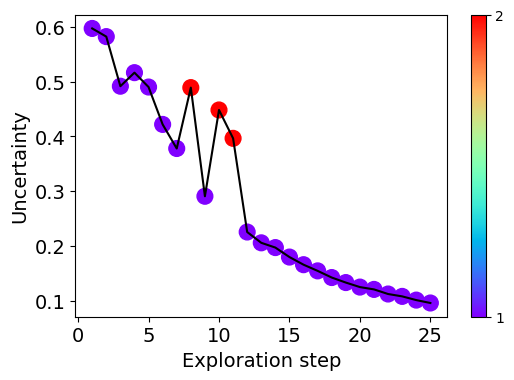

In [ ]:
plt.figure(dpi=100)
plt.plot(np.arange(1, exploration_steps+warmup_steps+1), var_history, c='k')
plt.scatter(np.arange(1, exploration_steps+warmup_steps+1), var_history,
            c=[m+1 for m in channel_choices],
            s=128, cmap='rainbow', alpha=1)
plt.xlabel("Exploration step", fontsize=14)
plt.ylabel("Uncertainty", fontsize=14)
plt.xticks(size=14)
plt.yticks(size=14)
cbar = plt.colorbar()
cbar.set_ticks([1, 2])

In [ ]:
var_history

[0.5969521045313958,
 0.5820496791009693,
 0.49144495704291896,
 0.5162097859082302,
 0.489945192143847,
 0.4216837147420165,
 0.3776730652808312,
 0.48889200871386745,
 0.29043194173257947,
 0.44805159599030636,
 0.3962401154183209,
 0.22512860788000666,
 0.20538905513007558,
 0.19669804724267176,
 0.1793784954467916,
 0.16543271089683537,
 0.1541473722965916,
 0.1419691065878108,
 0.13279573827064342,
 0.12454435406579219,
 0.12030947720701178,
 0.11189078082135685,
 0.10756149559746925,
 0.10077476226850647,
 0.0954844921222311]

In [ ]:
channel_choices

[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]